In [1]:
import json, os, math, random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
TRAINING = '/Users/user/data/research/proton-deuteron/ssvd/handpicked_d.pkl'

# TRAINING

In [20]:
IMG_H, IMG_W = 240, 3072                   # TODO: NEED TO PRESERVE A SENSE OF LENGTH PROPERLY
TILE_H, TILE_W = 15, 192
OCC_THRESH = 0.0

BATCH_SIZE = 128
FEAT_DIM = 128
LR = 3e-4
EPOCHS = 100
WEIGHT_DECAY = 1e-4                     # Learn about

PCT_THR = 90                             # PERCENTILE THRESHOLD FOR DEFINING DEUTERONS IN FEATURE SPACE

SEED = 0

OUT_DIR = "artifacts"
os.makedirs(OUT_DIR, exist_ok=True)

In [8]:
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.mps.manual_seed(SEED)

In [9]:
def pad_image(image, min_x, max_x, min_y, max_y, target_wh=(3072, 240)):
    target_w, target_h = target_wh
    canvas = np.zeros((target_h, target_w), dtype=image.dtype)

    h, w = image.shape

    y0 = max(0, min_y)
    y1 = min(target_h, min_y + h)
    x0 = max(0, min_x)
    x1 = min(target_w, min_x + w)

    img_y0 = max(0, -min_y)
    img_x0 = max(0, -min_x)
    img_y1 = img_y0 + (y1 - y0)
    img_x1 = img_x0 + (x1 - x0)

    if y0 < y1 and x0 < x1:
        canvas[y0:y1, x0:x1] = image[img_y0:img_y1, img_x0:img_x1]
    
    return canvas

from scipy.ndimage import zoom

def downsample_image(image, target_shape=(512, 40)):
    scale_y = target_shape[1] / image.shape[0]
    scale_x = target_shape[0] / image.shape[1]
    return zoom(image, (scale_y, scale_x), order=1) 

In [10]:
class DeutTrain(Dataset):
    def __init__(self, df, global_max_adc):
        self.df = df.reset_index(drop=True)
        self.gmax = float(global_max_adc)

    def __len__(self):
        return len(self.df)
    
    def _to_fixed(self, img):
        # TODO: NEED TO PRESERVE A SENSE OF LENGTH PROPERLY
        h, w, = img.shape
        out = np.zeros((IMG_H, IMG_W), dtype=np.float32)
        h0 = min(h, IMG_H)
        w0 = min(w, IMG_W)
        out[:h0, :w0] = img[:h0, :w0]
        return out
    
    def __getitem__(self, i):
        row = self.df.loc[i]

        img = np.asarray(row['image_intensity'], dtype=np.float32)
        
        x = pad_image(
            img,
            int(row['bbox_min_col']),
            int(row['bbox_max_col']),
            int(row['bbox_min_row']),
            int(row['bbox_max_row']),
        )
        
        x = downsample_image(x, target_shape=(IMG_W, IMG_H))

        ch0 = x / (self.gmax + 1e-6)
        
        mu, sd = float(x.mean()), float(x.std())
        if sd < 1e-6: sd = 1e-6
        ch1 = (x - mu) / sd

        x2 = np.stack([ch0, ch1], axis=0)                                           # (2, H, W)

        return torch.from_numpy(x2)

In [14]:
def extract_active_tiles(x, tile_h=15, tile_w=192, thresh=0.0):
    # x: (B, C, H, W)
    B, C, H, W = x.shape
    gy, gx = H // tile_h, W // tile_w
    patches = F.unfold(x, kernel_size=(tile_h, tile_w), stride=(tile_h, tile_w))  # (B, C*th*tw, gy*gx)
    patches = patches.transpose(1, 2).contiguous()  # (B, gy*gx, C*th*tw)
    tiles = patches.view(B, gy*gx, C, tile_h, tile_w)
    occ = tiles.abs().sum(dim=(2, 3, 4))  # (B, gy*gx)
    mask = occ > thresh
    batch_ids, tile_ids = torch.nonzero(mask, as_tuple=True)
    return tiles[batch_ids, tile_ids], batch_ids

class TileSparseCNN(nn.Module):
    """
    Processes only active tiles, then aggregates per-frame.
    Output: (B, feat_dim) embedding compatible with your SVDD code.
    """
    def __init__(self, in_ch=2, tile_feat=64, feat_dim=128):
        super().__init__()
        self.tile_net = nn.Sequential(
            nn.Conv2d(in_ch, 32, 3, stride=2, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),    nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
        )
        self.tile_head  = nn.Linear(64, tile_feat)
        self.frame_head = nn.Linear(tile_feat, feat_dim)

    def forward(self, x):                        # x: (B, C, H, W)
        tiles, batch_ids = extract_active_tiles(x)          # (N_act, C, th, tw), (N_act,)
        t = self.tile_net(tiles).flatten(1)                 # (N_act, 64)
        t = self.tile_head(t)                               # (N_act, tile_feat)

        # aggregate to per-frame embeddings (mean over that frame's active tiles)
        B = x.size(0)
        frame = torch.zeros(B, t.size(1), device=x.device, dtype=t.dtype)
        frame.index_add_(0, batch_ids, t)                   # sum per frame
        counts = torch.bincount(batch_ids, minlength=B).clamp_min(1).unsqueeze(1)
        frame = frame / counts
        return self.frame_head(frame)                       # (B, feat_dim)


In [15]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print('Device:', device)

print('Loading training dataset:', TRAINING)
df = pd.read_pickle(TRAINING)

global_max_adc = 2342.0                                                         # or try 1713.0 from the training data

print('Global max ADC:', global_max_adc)

ds = DeutTrain(df, global_max_adc)
dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

model = TileSparseCNN(in_ch=2, tile_feat=64, feat_dim=FEAT_DIM).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

Device: mps
Loading training dataset: /Users/user/data/research/proton-deuteron/ssvd/handpicked_d.pkl
Global max ADC: 2342.0


In [ ]:
# --- everything below stays identical ---
model.eval()
feats = []
with torch.no_grad():
    for batch in tqdm(dl, desc='Init centre'):
        batch = batch.to(device, non_blocking=True)
        feats.append(model(batch))
feats = torch.cat(feats, dim=0)
centre = feats.mean(dim=0).detach()

for epoch in range(1, EPOCHS+1):
    model.train()
    running, n = 0.0, 0
    for batch in dl:
        batch = batch.to(device, non_blocking=True)
        f = model(batch)
        loss = ((f - centre) ** 2).mean()
        opt.zero_grad(); loss.backward(); opt.step()
        bs = batch.size(0); running += loss.item() * bs; n += bs
    print(f'Epoch {epoch:03d}/{EPOCHS} loss={running/n:.8f}')

Init centre: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 001/100 loss=0.00000016
Epoch 002/100 loss=0.00000038


In [17]:
model.eval()
train_dists = []
with torch.no_grad():
    for batch in DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False):
        batch = batch.to(device)
        d = torch.norm(model(batch) - centre, dim=1)
        train_dists.extend(d.cpu().numpy())
    train_dists = np.asarray(train_dists, dtype=np.float32)

    thr = float(np.percentile(train_dists, PCT_THR))
    print(f'Chosen threshold @ P{PCT_THR:.1f} = {thr:.6f}')

Chosen threshold @ P90.0 = 0.005228


In [18]:
torch.save(model.state_dict(), os.path.join(OUT_DIR, 'svdd.pt'))
np.save(os.path.join(OUT_DIR, 'centre.npy'), centre.detach().cpu().numpy())
meta = {
    'img_h': IMG_H, 'img_w': IMG_W,
    'feat_dim': FEAT_DIM,
    'global_max_adc': float(global_max_adc),
    'threshold': thr,
    'percentile': PCT_THR,
    'seed': SEED
}
with open(os.path.join(OUT_DIR, 'threshold.json'), 'w') as f:
    json.dump(meta, f, indent=2)
print('Saved to', OUT_DIR)

Saved to artifacts


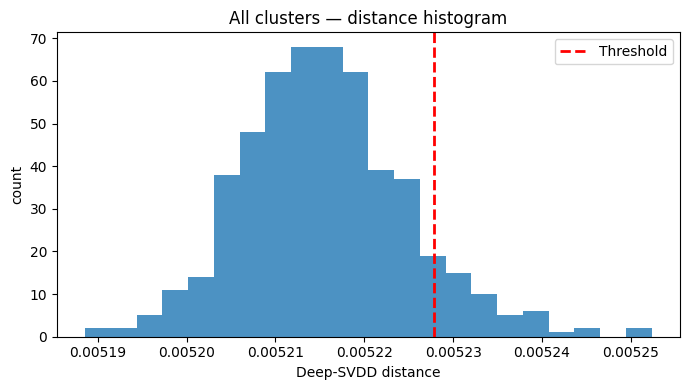

In [19]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# If df is already in memory with the column "score"
scores = train_dists.astype(float)

# bins = np.linspace(scores.min(), np.percentile(scores, 99.9), 200)

plt.figure(figsize=(7,4))
plt.hist(scores, bins='auto', alpha=0.8)
plt.axvline(thr, ls="--", lw=2, color='r', label='Threshold')
plt.xlabel("Deep-SVDD distance")
plt.ylabel("count")
plt.title("All clusters — distance histogram")
plt.legend()
plt.tight_layout(); plt.show()


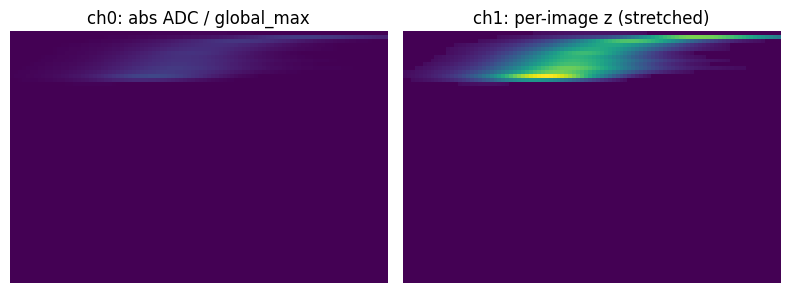

In [436]:
i = 0                      # random.randint(0, 500)  
x = ds[i]                 # shape: (2, H, W), on CPU
ch0 = x[0].numpy()
ch1 = x[1].numpy()

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Channel 0: scaled absolute ADC
axs[0].imshow(ch0, vmin=0.0, vmax=1.0)
axs[0].set_title("ch0: abs ADC / global_max")
axs[0].axis("off")

# Channel 1: z-score (stretch to [0,1] for display only)
z = ch1
z_disp = (z - z.min()) / (z.max() - z.min() + 1e-6)
axs[1].imshow(z_disp)
axs[1].set_title("ch1: per-image z (stretched)")
axs[1].axis("off")

plt.tight_layout()
plt.show()